# Rectangular Integration of RNA+ADT

In this tutorial, we demonstrate how to use MIDAS to integrate a rectangular dataset consisting of paired RNA (gene expression) and ADT (antibody-derived tags) data. We will walk through the entire process, from data setup and model training to inference and evaluation of the results.

## 1. Setting Up the Environment

First, we import the necessary libraries and configure the environment. This includes setting a specific CUDA device for GPU acceleration and ensuring reproducibility with a fixed random seed.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import subprocess
from pathlib import Path

import lightning as L
import numpy as np
import pandas as pd
import scanpy as sc

from scmidas.config import load_config
from scmidas.data import download_data, download_models, download_script
from scmidas.plot import plot_umap, plot_umap_grid
from scmidas.model import MIDAS

os.environ['CUDA_VISIBLE_DEVICES']='0'  # Set the GPU device to be used
sc.set_figure_params(figsize=(4, 4))    # Set plotting parameters for scanpy
L.seed_everything(42)                   # Set a global random seed for reproducibility

Seed set to 42


42

## 2. Downloading the Data

We will use a public dataset for this demonstration. The `task` variable defines the dataset name, which corresponds to a multi-batch (8 batches) RNA+ADT dataset in mtx format. The `download_data` function will automatically fetch and place it in the `dataset/` directory.

In [2]:
task = 'wnn_full_8batch_mtx'
download_data(task)

INFO:root:Downloading from https://pub-cfde59ed245349228f47377c9ae32dd3.r2.dev/wnn_full_8batch_mtx.zip.
INFO:root:Downloaded: https://pub-cfde59ed245349228f47377c9ae32dd3.r2.dev/wnn_full_8batch_mtx.zip to dataset/wnn_full_8batch_mtx.zip
INFO:root:Unzipped: dataset/wnn_full_8batch_mtx.zip to dataset


## 3. Configuring the Model

Next, we configure the MIDAS model. We start by loading the default configuration, which contains optimized hyperparameters for various tasks. We then instruct the model where to find the data and where to save the trained model artifacts.

In [3]:
configs = load_config()
configs['num_workers'] = 8  # Adjust based on your system's CPU cores for data loading
model = MIDAS.configure_data_from_dir(configs=configs, dir_path='dataset/'+task+'/data',
                                      save_model_path='saved_models/'+task)

INFO:root:The model is initialized with the default configurations.
INFO:root:Input data: 
      #CELL  #ADT  #RNA  #VALID_ADT  #VALID_RNA
p1_0   6378   224  3617         224        3617
p2_0   5899   224  3617         224        3617
p3_0   4628   224  3617         224        3617
p4_0   5285   224  3617         224        3617
p5_0   6952   224  3617         224        3617
p6_0   6060   224  3617         224        3617
p7_0   8854   224  3617         224        3617
p8_0   8908   224  3617         224        3617


## 4. Training the Model

We have two options: use a pre-trained model for a quick start or train the model from scratch to see the full process. For this demo, we will use the pre-trained version. To train from scratch, simply set `use_pretrained = False`.

In [ ]:
use_pretrained = True # To train from scratch, set it to False

if use_pretrained:
    download_models(task)
    model.load_checkpoint(f'saved_models/{task}.pt')
else:
    trainer = L.Trainer(max_epochs=1500)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    trainer.fit(model=model)

## 5. Generating Predictions

With a trained model, we can now perform inference.


In [5]:
outputs = model.predict(
			joint_latent=True,
			input=True,
			batch_correct=True,
			impute=True,
			translate=True,
			mod_latent=True,
            return_format='anndata'
			)
# Load labels.
for i in model.batch_names:
	outputs[i].obs['label'] = pd.read_csv('./dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten()
adata = sc.concat(outputs)

INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
INFO:root:Processing batch p1_0: ['adt', 'rna']
100%|██████████| 25/25 [00:01<00:00, 19.78it/s]
INFO:root:Processing batch p2_0: ['adt', 'rna']
100%|██████████| 24/24 [00:01<00:00, 21.96it/s]
INFO:root:Processing batch p3_0: ['adt', 'rna']
100%|██████████| 19/19 [00:01<00:00, 17.88it/s]
INFO:root:Processing batch p4_0: ['adt', 'rna']
100%|██████████| 21/21 [00:01<00:00, 16.11it/s]
INFO:root:Processing batch p5_0: ['adt', 'rna']
100%|██████████| 28/28 [00:01<00:00, 20.25it/s]
INFO:root:Processing batch p6_0: ['adt', 'rna']
100%|██████████| 24/24 [00:01<00:00, 18.23it/s]
INFO:root:Processing batch p7_0: ['adt', 'rna']
100%|██████████| 35/35 [00:01<00:00, 18.78it/s]
INFO:root:Processing batch p8_0: ['adt', 'rna']
100%|██████████| 35/35 [00:01<00:00, 19.31it/s]
INFO:root:Calculating u_centroid ...
INFO:root:Batch correction ...
INFO:root:Processing batch p1_0: ['adt', 'rna']
100%|██████████| 25/25 [00:01<00:00, 18.85it/s]
INF

## 6. Visualizing the Results

Now, let's visualize the outputs to assess the model's performance. First, we need to load the cell-type labels and batch identifiers for annotation.

### 6.1 Joint Embeddings

We infer the joint embedding `z`, which is composed of a biological component `c` and a technical component `u`.

... storing 'batch' as categorical
... storing 'label' as categorical


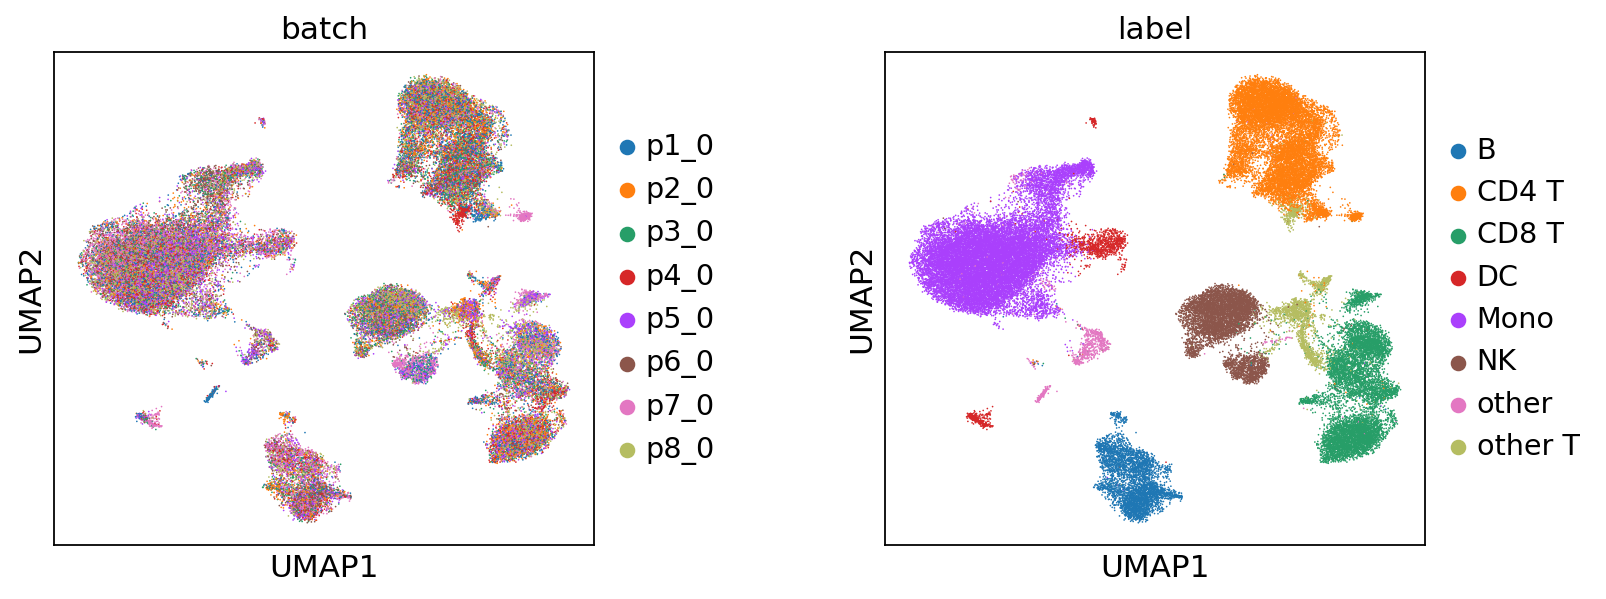

... storing 'batch' as categorical
... storing 'label' as categorical


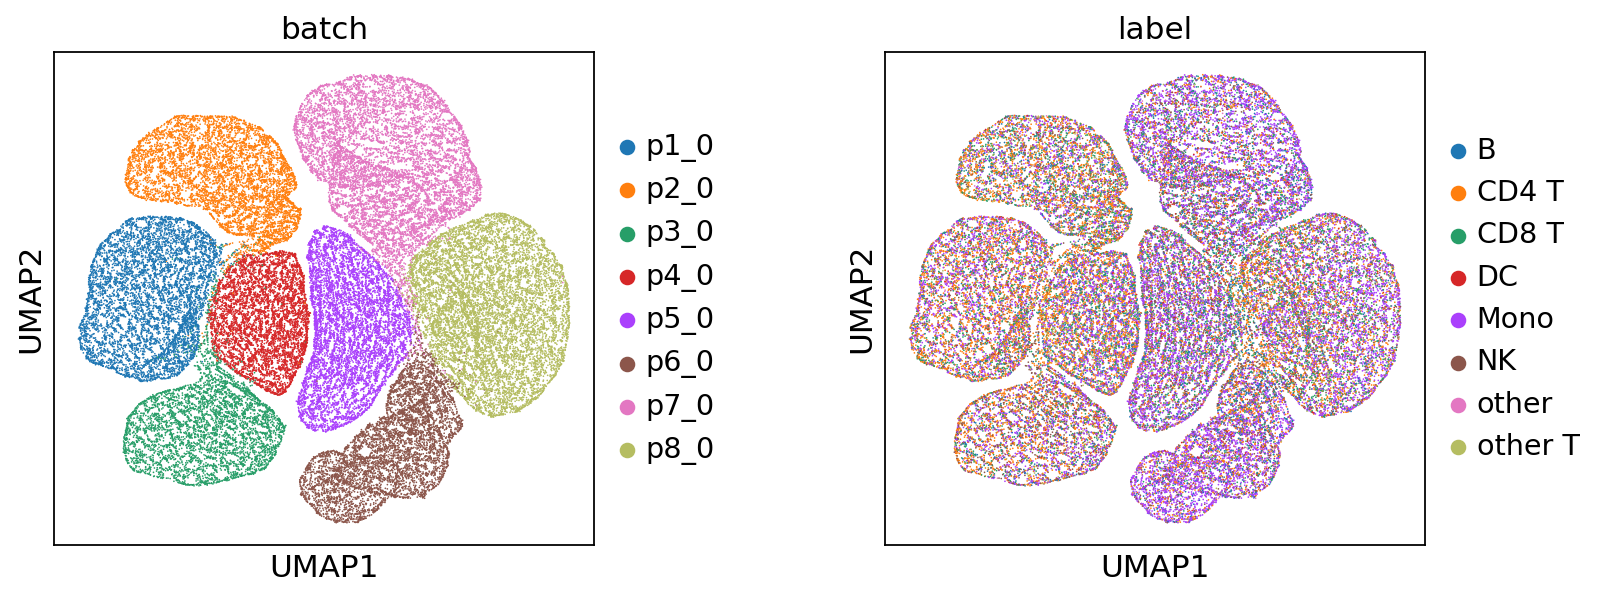

In [ ]:
# Biological State
plot_umap(adata, 'z_c_joint', color=['batch', 'label'], wspace=0.4)
# Technical Noise
plot_umap(adata, 'z_u_joint', color=['batch', 'label'], wspace=0.4)

### 6.2 Modality-Specific Embeddings

Here, we visualize the biological embeddings (`c`) for each modality (RNA, ADT) and for the joint representation, across all 8 batches. This helps us understand how well-aligned the different modalities are within each batch after being projected into the common latent space.

... storing 'axis1' as categorical
... storing 'axis2' as categorical
... storing 'label' as categorical


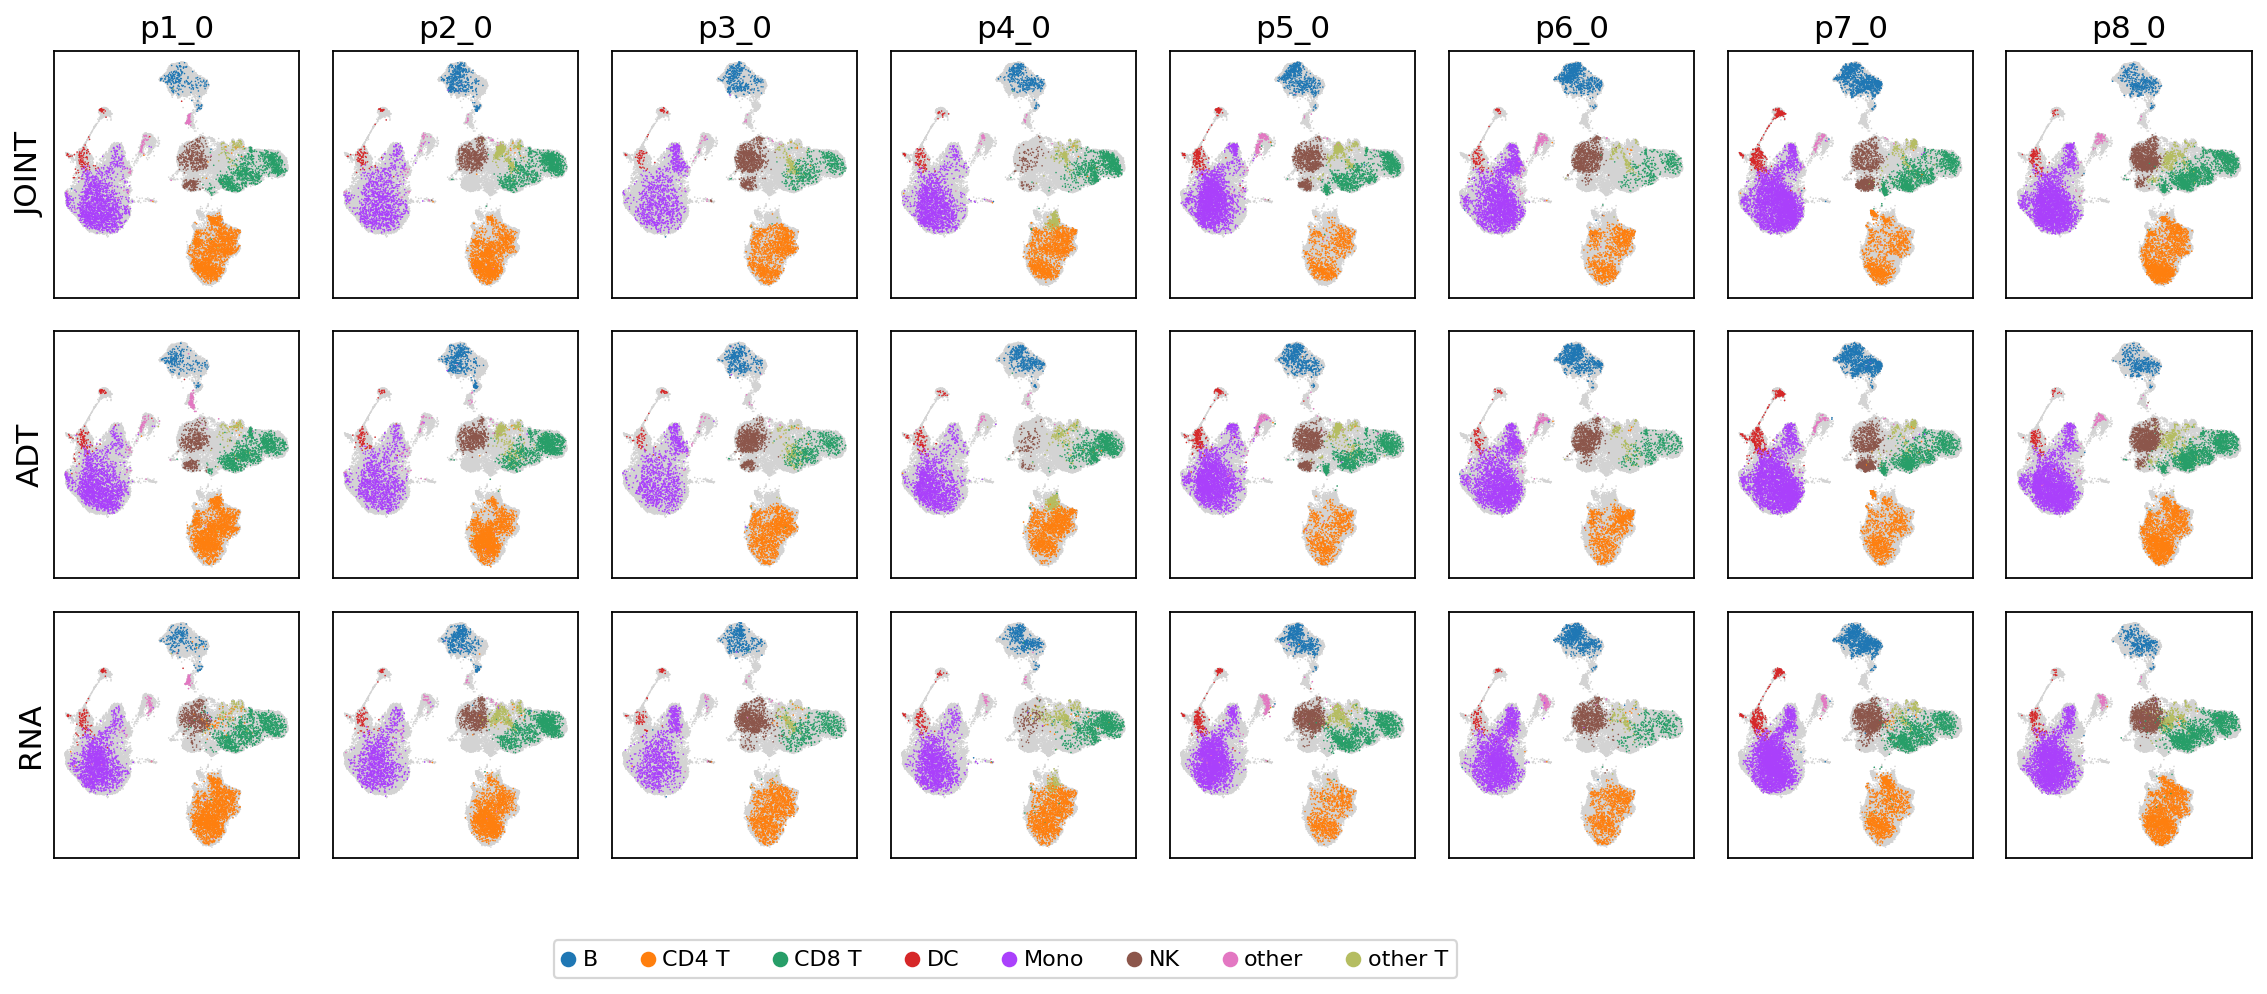

In [7]:
data_list, batch_list, cat_list, label_list = [], [], [], []

for batch, ad in outputs.items():
    valid_keys = [k for k in ad.obsm if k.startswith('z_c')]
    
    for k in valid_keys:
        data_list.append(ad.obsm[k])
        batch_list.append(ad.obs['batch'])
        
        cat_name = k.split('_')[-1].upper()
        cat_list.append(np.full(ad.n_obs, cat_name))
        label_list.append(pd.read_csv('./dataset/'+task+'/label/%s.csv'%batch, index_col=0).values.flatten())

data = np.concatenate(data_list)
axis1_ = np.concatenate(cat_list)
axis2_ = np.concatenate(batch_list)
label_ = np.concatenate(label_list)

ad = sc.AnnData(data)
ad.obs['axis1'] = axis1_
ad.obs['axis2'] = axis2_
ad.obs['label'] = label_
sc.pp.neighbors(ad, use_rep='X')
sc.tl.umap(ad)
plot_umap_grid(ad, 'axis1', 'axis2', color='label')

### 6.3 Batch-Corrected Data vs. Original Data

To externally validate the quality of MIDAS's batch-corrected count data, we will use a third-party algorithm, Seurat's Weighted Nearest Neighbor (WNN), to compute joint embeddings from both the batch-corrected and original counts.

For efficiency, we'll use a random sample of 2000 cells for the comparison.

In [8]:
N = 2000
select = np.random.choice(list(range(len(adata))), N, replace=False)
data = {
    'x_bc_rna' : adata.obsm['x_bc_rna'][select],
    'x_bc_adt' : adata.obsm['x_bc_adt'][select],
    'x_rna' : adata.obsm['x_rna'][select],
    'x_adt' : adata.obsm['x_adt'][select],
}

Now, we will loop through the batch-corrected and original data. For each, we save the subsampled data to disk, execute the R script to perform WNN and UMAP, and then load and plot the results.

'wnn_bimodal.R' already exists. Skipping download.


... storing 'batch' as categorical
... storing 'label' as categorical



Python: Executing R script 'wnn_bimodal.R' for Batch-Corrected Data...



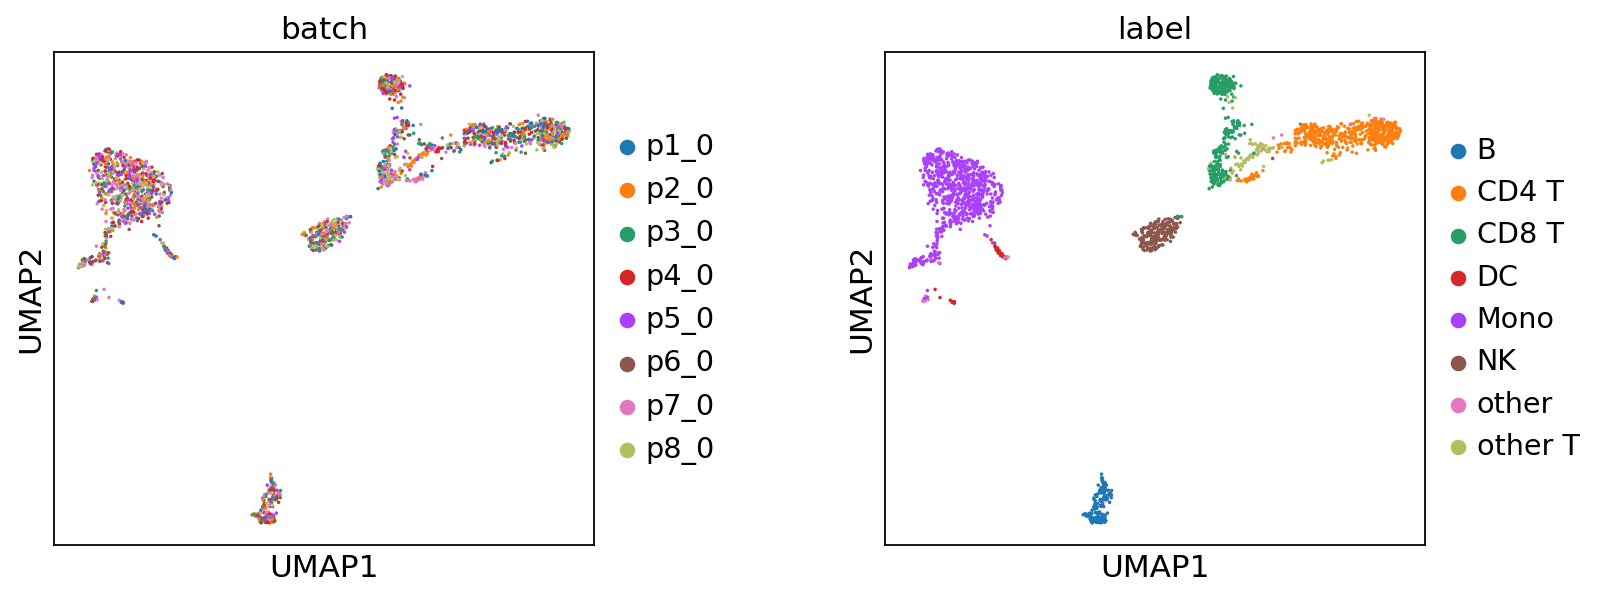

... storing 'batch' as categorical
... storing 'label' as categorical



Python: Executing R script 'wnn_bimodal.R' for Original Data...



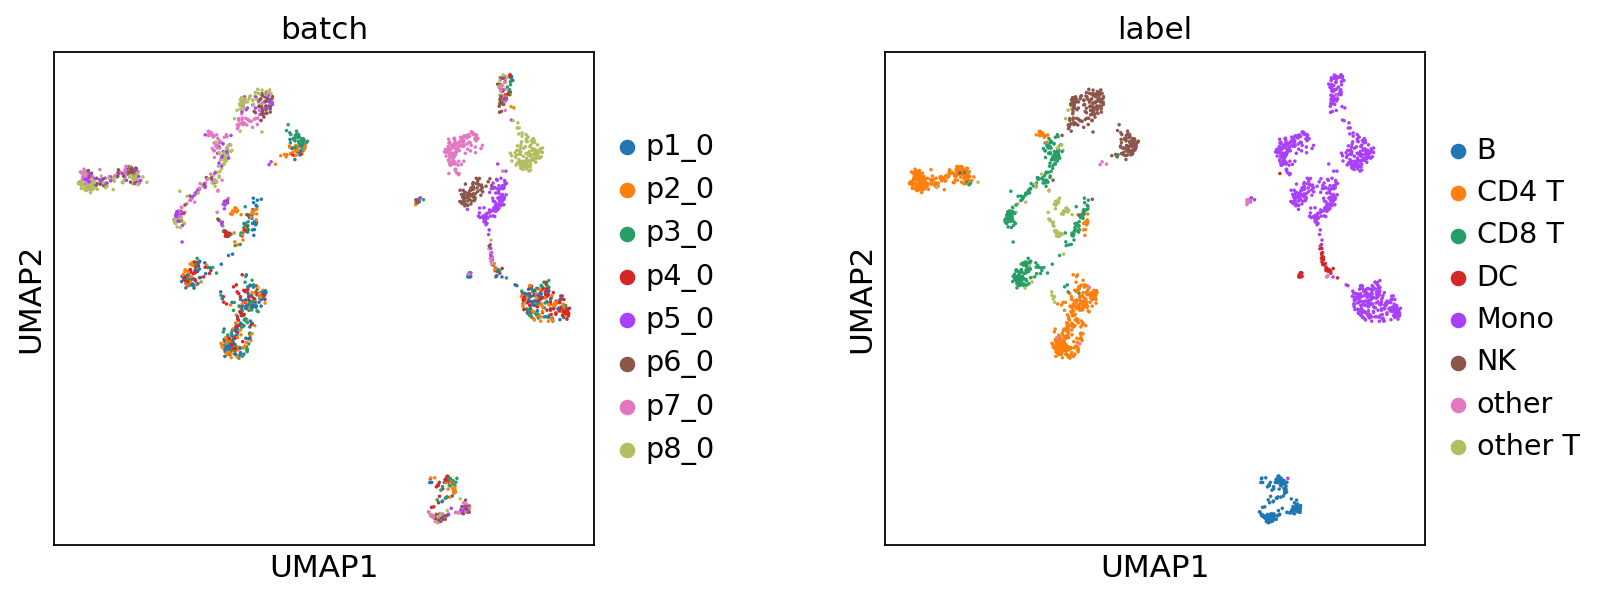

In [13]:
temp_dirs = {"Batch-Corrected Data": 'demo1_temp/x_bc/', "Original Data": 'demo1_temp/x/'}
r_script_file = 'wnn_bimodal.R' # R script for WNN analysis on RNA+ADT data
download_script(r_script_file)

for name, temp_dir in temp_dirs.items():
	# 1. Save Python data to disk for the R script to access
	os.makedirs(temp_dir, exist_ok=True)
	data_key = Path(temp_dir).name  # 'x_bc' or 'x'
	pd.DataFrame(data[data_key+'_rna']).T.to_csv(temp_dir+'rna.csv', index=True)
	pd.DataFrame(data[data_key+'_adt']).T.to_csv(temp_dir+'adt.csv', index=True)

	# 2. Execute the R script via a subprocess
	print(f"\nPython: Executing R script '{r_script_file}' for {name}...\n")
	command = ['Rscript', '--vanilla', r_script_file, temp_dir]
	result = subprocess.run(command, check=True, capture_output=True, text=True)
	# print(result.stdout) # uncomment this line to see the R script's output

	# 3. Load the UMAP results generated by R and plot them
	ad = adata[select]
	ad.obsm['umap'] = pd.read_csv(temp_dir+'umap_coords.csv', index_col=0).values
	# shuffle
	sc.pp.subsample(ad, fraction=1)
	sc.pl.umap(ad, color=['batch', 'label'], size=10, wspace=0.4)